
Processing for N = 50 particles...
  Sampling initial conditions for N=50 using Metropolis-Hastings...
  Initial conditions sampled. Time: 0.02s
  beta = 0
    Calculating Reference Solution for N=50, beta=0...
    Ref Sol: Step 0/32768
    Ref Sol: Step 3276/32768
    Ref Sol: Step 6552/32768
    Ref Sol: Step 9828/32768
    Ref Sol: Step 13104/32768
    Ref Sol: Step 16380/32768
    Ref Sol: Step 19656/32768
    Ref Sol: Step 22932/32768
    Ref Sol: Step 26208/32768
    Ref Sol: Step 29484/32768
    Ref Sol: Step 32760/32768
    Reference solution calculated. Time: 63.53s
    tau = 0.00781 (K_RBM = 128 macro steps), N_RBM_AVG_RUNS=1
    RBM solutions calculated. Avg RBM Time: 0.05s/run
      N=50, beta=0, tau=0.00781, Avg_Error_E_hat=2.250e-02
    tau = 0.01562 (K_RBM = 64 macro steps), N_RBM_AVG_RUNS=1
    RBM solutions calculated. Avg RBM Time: 0.02s/run
      N=50, beta=0, tau=0.01562, Avg_Error_E_hat=4.168e-02
    tau = 0.03125 (K_RBM = 32 macro steps), N_RBM_AVG_RUNS=1
    RBM

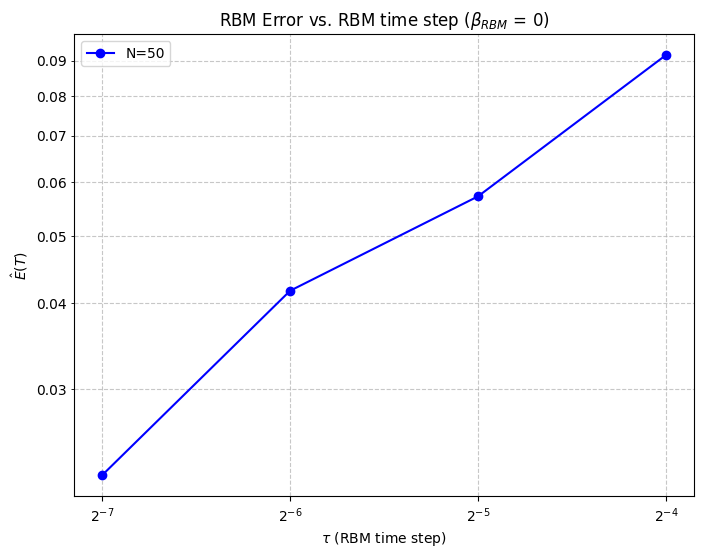

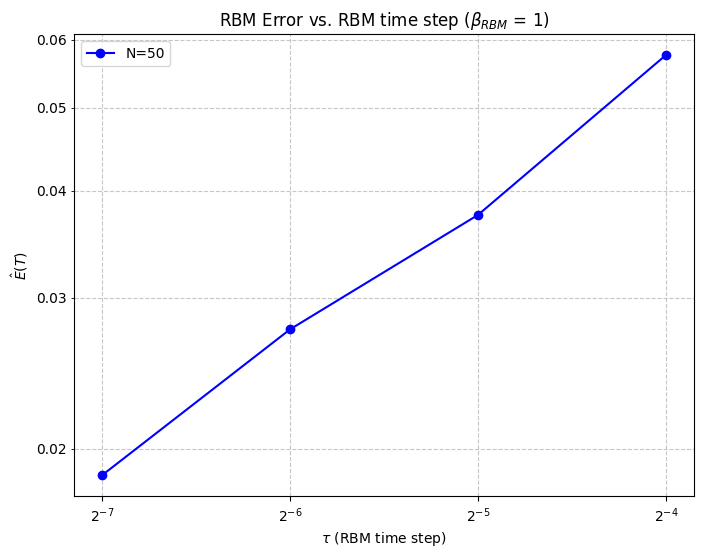

In [9]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FormatStrFormatter # For tick formatting

# =======================================================
# --- Functions ---
# =======================================================

def semicircle_pdf(x, radius=2.0):
    """
    Probability density function (unnormalized) for Wigner semicircle.
    pdf(x) = sqrt(radius^2 - x^2) for |x| <= radius, 0 otherwise.
    The normalization constant is 1/(pi * radius^2 / 2), but M-H works with unnormalized.
    """
    if np.abs(x) <= radius:
        return np.sqrt(radius**2 - x**2)
    else:
        return 0

def sample_initial_conditions_semicircle_metropolis_hastings(N, radius=2, steps=1000, burn_in=100, proposal_std=0.5):
    """
    Samples N initial conditions from the Wigner semicircle distribution
    using the Metropolis-Hastings algorithm.

    Parameters:
    N (int): Number of samples to generate.
    radius (float): Radius of the semicircle.
    steps (int): Number of M-H steps per sample (after burn-in).
    burn_in (int): Number of initial M-H steps to discard.
    proposal_std (float): Standard deviation for the normal proposal distribution.

    Returns:
    numpy.ndarray: Array of N samples.
    """
    samples = np.zeros(N)
    x_current = 0  # Start at the center or a random point within [-radius, radius]

    # Burn-in phase
    for _ in range(burn_in):
        x_proposed = x_current + np.random.normal(0, proposal_std)
        # Simple reflection if it goes out of bounds, or just reject
        # For Wigner, we need it to be within [-radius, radius] for pdf to be non-zero
        if np.abs(x_proposed) > radius :
             # If proposal is outside domain, its pdf is 0, so acceptance ratio involving f(proposed)/f(current) is 0 if f(current)>0
             # Or, if we want to ensure proposals are always in domain, we can reflect or use a different proposal.
             # For simplicity, if it goes out, the PDF is 0, acceptance ratio for moving there will be 0 if current is valid.
             # A more robust way is to ensure proposals are within [-R, R] or handle P(x_proposed)=0 carefully
             pass # PDF will be 0, likely rejected if x_current is valid

        acceptance_ratio = 0
        pdf_current = semicircle_pdf(x_current, radius)
        if pdf_current > 0: # Avoid division by zero if x_current somehow became invalid
            pdf_proposed = semicircle_pdf(x_proposed, radius)
            acceptance_ratio = pdf_proposed / pdf_current
        
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposed

    # Sampling phase
    for i in range(N):
        for _ in range(steps): # Run M-H for a few steps to get less correlated samples
            x_proposed = x_current + np.random.normal(0, proposal_std)

            acceptance_ratio = 0.0
            pdf_current = semicircle_pdf(x_current, radius)
            if pdf_current > 0:
                pdf_proposed = semicircle_pdf(x_proposed, radius)
                acceptance_ratio = pdf_proposed / pdf_current

            if np.random.rand() < acceptance_ratio:
                x_current = x_proposed
        samples[i] = x_current
        
    # Optional: Check distribution if N is large
    # if N > 1000:
    #     plt.hist(samples, bins=50, density=True, label='Sampled Initial Conditions')
    #     x_vals = np.linspace(-radius, radius, 200)
    #     y_vals = [semicircle_pdf(x, radius) for x in x_vals]
    #     norm_factor = np.pi * radius**2 / 2 # This is for semicircle area, not PDF height
    #     # For PDF: integral from -R to R of 2/(pi R^2) * sqrt(R^2-x^2) dx = 1
    #     pdf_y_vals = (2.0 / (np.pi * radius**2)) * np.array(y_vals)
    #     plt.plot(x_vals, pdf_y_vals, label='True Semicircle PDF (scaled)')
    #     plt.legend()
    #     plt.title("Initial Condition Distribution Check")
    #     plt.show()
        
    return samples

def solve_fully_coupled_system_euler(X0, beta, sigma, T, K, verbose=False): # Added verbose
    """
    Solves the fully coupled N-particle system using Forward Euler.
    dX_i = -beta * X_i dt + (1/(N-1)) * sum_{j!=i} K(Xi,Xj) dt + sigma dW
    """
    N = len(X0)
    X_ref = np.copy(X0)
    tau = T / K

    if N <= 1:
        # Simplified handling for N=1 (no interaction)
        for _ in range(K):
            dW = np.sqrt(tau) * np.random.randn() if sigma > 0 else 0
            drift = -beta * X_ref[0]
            X_ref[0] = X_ref[0] + drift * tau + sigma * dW
        return X_ref

    for k_step in range(K):
        X_new = np.zeros_like(X_ref) # Store updates for simultaneous update
        dW = np.sqrt(tau) * np.random.randn(N) if sigma > 0 else np.zeros(N)
        
        # Pre-calculate all interactions for efficiency if N is large,
        for i in range(N):
            interaction_force = 0
            for j in range(N):
                if i == j:
                    continue
                diff = X_ref[i] - X_ref[j]
                interaction_force += diff / (1.0 + diff**2)

            drift = -beta * X_ref[i] + (1.0 / (N - 1.0)) * interaction_force
            X_new[i] = X_ref[i] + drift * tau + sigma * dW[i]
        X_ref = X_new # Simultaneous update
        if verbose and k_step % (K // 10) == 0 and K >=10 :
             print(f"    Ref Sol: Step {k_step}/{K}")
    return X_ref


def solve_rbm1_euler(X0, beta, sigma, T, p, K, verbose=False): # Added verbose
    """
    Solves the system using RBM-1. Each macro RBM step is one Euler step of size tau.
    """
    N = len(X0)
    X_rbm = np.copy(X0)
    tau = T / K

    if p <= 1 and N > 1 :
        if N > 1 and p == 1 : # No interaction if batch size is 1
             for m in range(K):
                for i in range(N):
                    X_new = X_rbm[i]
                    drift = -beta * X_new
                    dW = np.sqrt(tau) * np.random.randn() if sigma > 0 else 0
                    X_rbm[i] = X_new + drift * tau + sigma * dW
                if verbose and m % (K // 10) == 0 and K >= 10:
                    print(f"    RBM Sol (p=1): Macro Step {m}/{K}")
             return X_rbm
        else: # p < 1 is an error
            print("Error: p <=1 for RBM (or N=1 with p>1)")
            return X_rbm # Or raise error

    for m in range(K):
        indices = np.random.permutation(N)
        
        # Store updates for this macro step to apply simultaneously if desired,
        # but sequential updates within a macro step for different batches is standard.
        # Particles are updated based on values from the *beginning* of the macro step's batches.
        X = np.copy(X_rbm) # Work on a copy for this macro step's drift calcs

        for i in range(0, N, p):
            batch_indices = indices[i : i + p]
            
            # If the last batch is smaller than p
            batch_p = len(batch_indices)
            if batch_p <=1 and N > 1: # single particle left over
                if batch_p == 1:
                    idx = batch_indices[0]
                    X_new = X_rbm[idx] # Value from start of macro step
                    drift = -beta * X_new # No interaction
                    dW = np.sqrt(tau) * np.random.randn() if sigma > 0 else 0
                    X[idx] = X_new + drift * tau + sigma * dW
                continue # Move to next batch if any

            # Calculate drift for particles in this batch based on X_rbm (values at start of macro step)
            batch_drifts = np.zeros(batch_p)
            X_batch = X_rbm[batch_indices]

            for i_idx, i in enumerate(batch_indices):
                current_drift = X_batch[i_idx]
                interaction_force = 0
                num_others = 0
                for j_idx, j in enumerate(batch_indices):
                    if i != j:
                        other_drift = X_batch[j_idx]
                        diff = current_drift - other_drift
                        interaction_force += diff / (1 + diff**2)
                        num_others += 1
                
                interaction_term = 0
                # Divisor is (p-1), i.e. num_others
                if num_others > 0:
                    interaction_term = (1 / num_others) * interaction_force
                
                batch_drifts[i_idx] = -beta * current_drift + interaction_term

            # Update particles in the batch using calculated drifts
            # These updates use X_rbm (values from *start* of macro step m) to calculate drift
            # then apply to X
            for i_idx, i in enumerate(batch_indices):
                dW = np.sqrt(tau) * np.random.randn() if sigma > 0 else 0
                X[i] = X_batch[i_idx] + batch_drifts[i_idx] * tau + sigma * dW
        X_rbm = X # All particles updated for this macro step

        if verbose and m % (K // 10) == 0 and K >= 10:
            print(f"    RBM Sol: Macro Step {m}/{K}")
            
    return X_rbm

def calculate_rbm_error(X_rbm, X_ref):
    if len(X_rbm) != len(X_ref):
        raise ValueError("RBM and Reference solutions must have the same number of particles.")
    if len(X_rbm) == 0:
        return 0.0
    error_sq_sum = np.sum((X_rbm - X_ref)**2)
    return np.sqrt(error_sq_sum / len(X_rbm))


# =======================================================
# --- Parameters ---
# =======================================================
T = 1
N_values = [50]

p = 2
beta_values = [0, 1]

sigma = 0 # Deterministic dynamics for Fig 2, noise from RBM is only shuffling

tau_powers = [-7, -6, -5, -4]
tau_values = [2**pow for pow in tau_powers]

K = 2**15
radius = 2.0

# Metropolis-Hastings parameters for initial condition sampling
steps = 20 # Number of M-H steps to take for each particle after burn-in
burn_in = 500       # Initial M-H steps to discard
proposal_std = 0.8  # Proposal step size for M-H

# Averaging RBM Error
N_RBM_AVERAGE_RUNS = 1 # Number of RBM runs to average error over for smoother plots
                        # Paper doesn't specify, but plots are smooth. Use 1 for quickest test.
                        # If N_RBM_AVERAGE_RUNS = 1, it's one realization of shuffling.


# =======================================================
# --- Main Simulation Loop ---
# =======================================================
figure2_results = []
simulation_start_time = time.time()
np.random.seed(42) # For reproducibility of M-H and shuffles if N_RBM_AVERAGE_RUNS = 1

print_ref_progress = True # Control verbosity for reference solution calculation

for N in N_values:
    print(f"\nProcessing for N = {N} particles...")
    
    print(f"  Sampling initial conditions for N={N} using Metropolis-Hastings...")
    init_cond_time_start = time.time()
    X0 = sample_initial_conditions_semicircle_metropolis_hastings(
        N, radius, steps, burn_in, proposal_std
    )
    init_cond_time_end = time.time()
    print(f"  Initial conditions sampled. Time: {init_cond_time_end - init_cond_time_start:.2f}s")
    
    for beta in beta_values:
        print(f"  beta = {beta}")
        
        print(f"    Calculating Reference Solution for N={N}, beta={beta}...")
        ref_start_time = time.time()
        X_ref = solve_fully_coupled_system_euler(
            X0, beta, sigma, T, K, verbose=print_ref_progress
        )
        ref_end_time = time.time()
        print(f"    Reference solution calculated. Time: {ref_end_time - ref_start_time:.2f}s")

        for tau in tau_values:
            K_rbm = int(round(T / tau)) # Use round for robustness
            print(f"    tau = {tau:.5f} (K_RBM = {K_rbm} macro steps), N_RBM_AVG_RUNS={N_RBM_AVERAGE_RUNS}")
            
            errors = np.zeros(N_RBM_AVERAGE_RUNS)
            rbm_time = 0
            
            for rbm_run_idx in range(N_RBM_AVERAGE_RUNS):
                # print(f"      RBM Avg Run {rbm_run_idx+1}/{N_RBM_AVERAGE_RUNS}...")
                # RBM starts from the SAME X0 for each of these averaging runs
                # but the shuffling will be different each time.
                rbm_start_time = time.time()
                X_rbm = solve_rbm1_euler(
                    X0, beta, sigma, T, 
                    p, K_rbm, verbose=False # Less verbose for inner RBM runs
                )
                rbm_end_time = time.time()
                rbm_time += (rbm_end_time - rbm_start_time)
                errors[rbm_run_idx] = calculate_rbm_error(X_rbm, X_ref)

            avg_error = np.mean(errors)
            avg_rbm_time = rbm_time / N_RBM_AVERAGE_RUNS
            print(f"    RBM solutions calculated. Avg RBM Time: {avg_rbm_time:.2f}s/run")
            
            figure2_results.append({
                "N": N,
                "beta": beta,
                "tau": tau,
                "Error_E_hat": avg_error
            })
            print(f"      N={N}, beta={beta}, tau={tau:.5f}, Avg_Error_E_hat={avg_error:.3e}")

simulation_end_time = time.time()
print(f"\nTotal simulation time: {simulation_end_time - simulation_start_time:.2f} seconds.")


# =======================================================
# --- Display Results ---
# =======================================================
df_fig2_results = pd.DataFrame(figure2_results)
print("\n--- Results for Figure 2 Data Points (Averaged RBM Error) ---")
# Format for better readability
df_print_fig2 = df_fig2_results.copy()
df_print_fig2["tau"] = df_print_fig2["tau"].map('{:.5f}'.format)
df_print_fig2["Error_E_hat"] = df_print_fig2["Error_E_hat"].map('{:.3e}'.format)
print(df_print_fig2.to_string(index=False))


# =======================================================
# --- Plotting ---
# =======================================================
if True: 
    for b in df_fig2_results["beta"].unique():
        plt.figure(figsize=(8, 6))
        plot_beta = df_fig2_results[df_fig2_results["beta"] == b]
        
        # Define markers and colors as in the paper (approximate)
        markers = ['o', '*', 's'] # circle, star, square
        colors = ['blue', 'black', 'red'] # As per Fig 2 caption: N=50 blue circle, N=500 black star, N=2000 red square

        sorted_N = sorted(plot_beta["N"].unique())

        for i, n in enumerate(sorted_N):
            plot_N = plot_beta[plot_beta["N"] == n]
            # Sort by tau for consistent plotting lines
            plot_N = plot_N.sort_values(by="tau")
            plt.plot(plot_N["tau"], plot_N["Error_E_hat"], 
                     marker=markers[i % len(markers)], 
                     color=colors[i % len(colors)],
                     linestyle='-', 
                     label=f'N={n}')
        
        plt.xscale('log', base=2)
        plt.yscale('log')
        plt.xlabel(r'$\tau$ (RBM time step)') # Using tau as in paper's Fig 2
        plt.ylabel(r'$\hat{E}(T)$')
        plt.title(f'RBM Error vs. RBM time step ($\\beta_{{RBM}}$ = {b})')
        plt.legend()
        plt.grid(True, which="both", ls="--", alpha=0.7)
        plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}')) # 2 decimal places
        plt.gca().yaxis.set_minor_formatter(FormatStrFormatter("%.2f")) # 2 decimal places for minor ticks
      
        sorted_tau = sorted(list(df_fig2_results["tau"].unique()))
        xtick_labels_powers = [int(np.log2(val)) for val in sorted_tau]
        xtick_labels = [f'$2^{{{pow}}}$' for pow in xtick_labels_powers]
        plt.xticks(sorted_tau, xtick_labels)
        plt.show()